In [1]:
import random
import numpy as np
import tensorflow as tf

SEED = 42 

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Folder: Closed
Number of images: 660


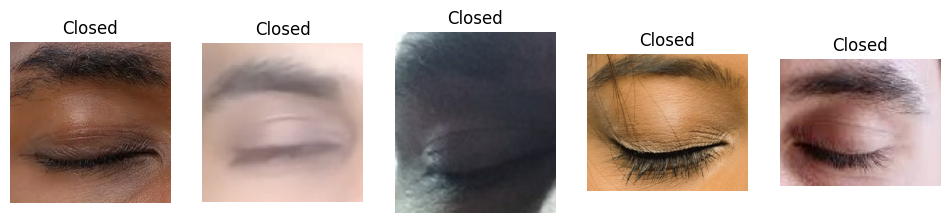

⚠️ Images in Closed are of different sizes

Folder: Open
Number of images: 663


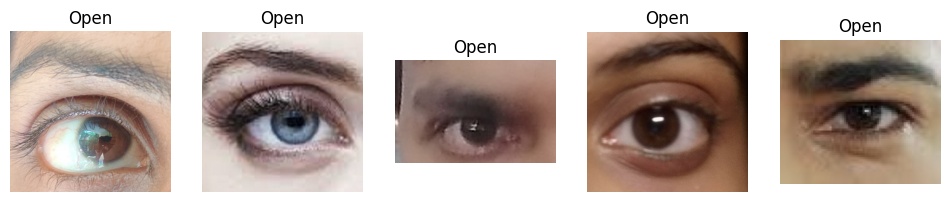

⚠️ Images in Open are of different sizes

Folder: yawn
Number of images: 723


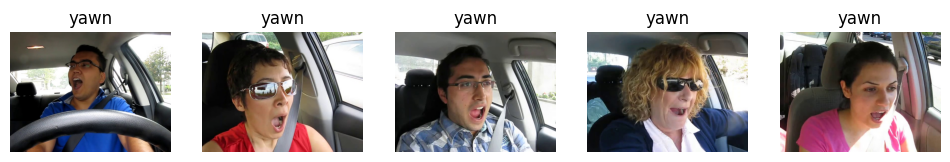

✅ All images in yawn are of the same size: (480, 640)

Folder: no_yawn
Number of images: 725


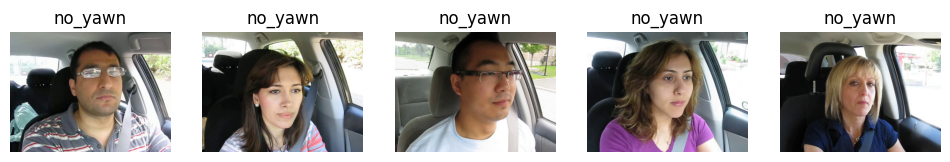

✅ All images in no_yawn are of the same size: (480, 640)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


# dataset path
data_dir = '/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train'

# folders inside train
folders = ['Closed', 'Open', 'yawn', 'no_yawn']

# dictionary to store counts
image_counts = {}

# loop through folders
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    images = os.listdir(folder_path)
    image_counts[folder] = len(images)
    
    print(f"\nFolder: {folder}")
    print(f"Number of images: {len(images)}")
    
    # plot 5 sample images
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images[:5]):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(folder)
    plt.show()
    
    # check image sizes
    sizes = set()
    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            sizes.add(img.shape[:2])  # (height, width)
    
    if len(sizes) == 1:
        print(f"✅ All images in {folder} are of the same size: {list(sizes)[0]}")
    else:
        print(f"⚠️ Images in {folder} are of different sizes")

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import seaborn as sns
import pathlib

# -------------------------
# User config / hyperparams
# -------------------------
data_dir = '/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train'  # CHANGE if needed
TARGET_CLASSES = ['yawn', 'no_yawn']
IMG_SIZE = (224, 224)        # fixed size for both custom and transfer models
BATCH_SIZE = 32
SEED = 42
EPOCHS_CUSTOM = 50
EPOCHS_TL = 20
LEARNING_RATE = 1e-3

In [4]:
# -------------------------
# Verify dataset & counts
# -------------------------
for c in TARGET_CLASSES:
    p = os.path.join(data_dir, c)
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Expected directory for class '{c}' at: {p}")
    count = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
    print(f"Class '{c}': {count} images")

Class 'yawn': 723 images
Class 'no_yawn': 725 images


In [5]:
# 1. Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=["yawn", "no_yawn"],
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,   # 70% train, 30% val+test
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=["yawn", "no_yawn"],
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

# 2. Save class names BEFORE caching/prefetch
class_names = train_ds.class_names
print("Class names (inferred):", class_names)

# 3. Split val_test_ds into val/test
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print("\nDataset sizes (batches):")
print("Train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test:", tf.data.experimental.cardinality(test_ds).numpy())

# 4. Now apply cache/prefetch (after saving class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1448 files belonging to 2 classes.
Using 1014 files for training.


I0000 00:00:1764126242.336567      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764126242.337325      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1448 files belonging to 2 classes.
Using 434 files for validation.
Class names (inferred): ['yawn', 'no_yawn']

Dataset sizes (batches):
Train: 32
Val: 7
Test: 7


In [6]:
# print(train_ds.shape)
print(type(train_ds))
print(train_ds)

# print(val_ds.shape)
print(type(val_ds))
print(val_ds)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


/tmp/ipykernel_47/4035756159.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # float→int


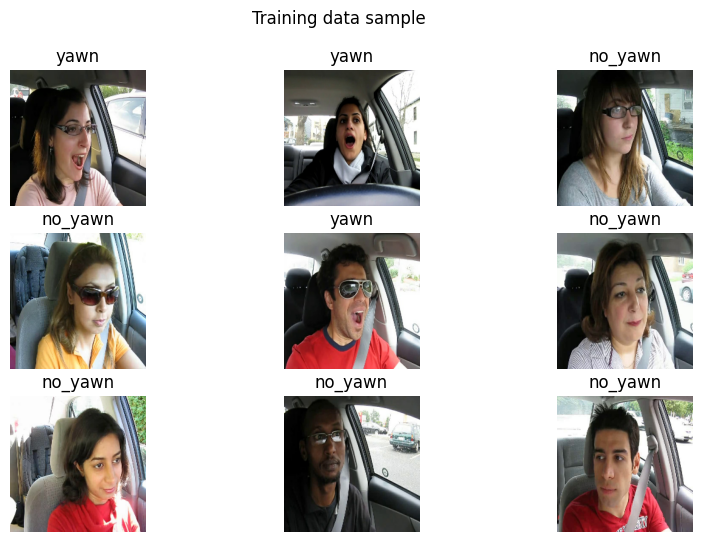

In [7]:

# -------------------------
# Optional: visualize some samples
# -------------------------
def show_batch(dataset, title="Sample images"):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = int(labels[i].numpy())  # float→int
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training data sample")

In [8]:
# -------------------------
# Data augmentation + preprocessing layers
# -------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.06),
], name="data_augmentation")

# Normalization layer (rescale pixels 0-1)
rescale = layers.Rescaling(1./255)

## **CNN Model Version 1**

In [9]:
# -------------------------
# Build Custom CNN (from scratch)  --> (3,) is for 3 channels
# GlobalAveragePooling2D() and GlobalMaxPooling2D() convert 2D feature maps into 1D feature vectors, so no need of flattern layer .
# -------------------------

def build_custom_cnn(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = rescale(x)
    # Conv block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    # Conv block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    # Conv block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # binary
    model = keras.Model(inputs, outputs, name='custom_cnn')
    return model

In [10]:
CNN_model_V1 = build_custom_cnn()
CNN_model_V1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
CNN_model_V1.summary()

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

## **CNN Model with CBAM V1**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# -------------------------
# CBAM block

# Channel Attention:
# Used both Global Average Pooling and Global Max Pooling.
# Passed both through a shared MLP with two dense layers:
# First layer units: channel // ratio
# Second layer units: channel
# Added the outputs and passed through a sigmoid.
# Reshaped and multiplied with the input feature.

# Spatial Attention:
# Computed average and max pooling along channel axis.
# Concatenated both.
# Used a 7x7 Conv2D with sigmoid activation.
# Multiplied attention map with input.

# -------------------------

def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module (CBAM)"""

    channel = input_feature.shape[-1]

    # -------- Channel Attention --------
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    # Shared MLP
    shared_dense_1 = layers.Dense(channel // ratio, activation='relu') # ( 2 layers first contains c/r unit)
    shared_dense_2 = layers.Dense(channel)                             # (second layer contains c unit)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)

    x = layers.Multiply()([input_feature, channel_attention])

    # -------- Spatial Attention --------
    avg_pool_spatial = layers.Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x

# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(inputs)  # BUG: you replaced x with inputs again!
# This is wrong, so we cant able to see data augumentation layer in model.summary()

# -------------------------
# Build Custom CNN with CBAM
# -------------------------
def build_custom_cnn_cbam(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = rescale(x)  # simple rescale

    # ----- Conv Block 1 -----
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 2 -----
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 3 with CBAM -----
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # binary classification

    model = keras.Model(inputs, outputs, name='custom_cnn_cbam')
    return model

# -------------------------
# Compile model
# -------------------------
LEARNING_RATE = 1e-3
IMG_SIZE = (224, 224)

CNN_CBAM_model_V1 = build_custom_cnn_cbam(input_shape=IMG_SIZE + (3,))
CNN_CBAM_model_V1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

CNN_CBAM_model_V1.summary()

Model: "custom_cnn_cbam"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │        896 │ rescaling[1][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      2,064 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      2,176 │ dense_2[0][0],    │
│                     │                   │            │ dense_2[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_3[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ add[0][0]       

 Total params: 115,124 (449.70 KB)

 Trainable params: 114,676 (447.95 KB)

 Non-trainable params: 448 (1.75 KB)

## **CNN with CBAM V2**

In [12]:

def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module (CBAM)"""

    channel = input_feature.shape[-1]

    # -------- Channel Attention --------
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    # Shared MLP
    shared_dense_1 = layers.Dense(channel // ratio, activation='relu') # ( 2 layers first contains c/r unit)
    shared_dense_2 = layers.Dense(channel)                             # (second layer contains c unit)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)

    x = layers.Multiply()([input_feature, channel_attention])

    # -------- Spatial Attention --------
    avg_pool_spatial = layers.Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x


def build_custom_cnn_cbam_v2(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)

    #  Data Augmentation + Normalization
    x = data_augmentation(inputs)
    x = rescale(x)

    # ----- Conv Block 1 -----
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 2 -----
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 3 -----
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 4 With CBAM -----
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    # 🔹 Global Pooling (both Avg + Max)
    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([gap, gmp])

    # 🔹 Dense Layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='custom_cnn_cbam_v2')
    return model


# -------------------------
# Compile model
# -------------------------
LEARNING_RATE = 1e-3
IMG_SIZE = (224, 224)

CNN_CBAM_model_V2 = build_custom_cnn_cbam_v2(input_shape=IMG_SIZE + (3,))
CNN_CBAM_model_V2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

CNN_CBAM_model_V2.summary()

Model: "custom_cnn_cbam_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │        896 │ rescaling[2][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      8,224 │ global_average_p

 Total params: 538,692 (2.05 MB)

 Trainable params: 537,732 (2.05 MB)

 Non-trainable params: 960 (3.75 KB)

### **Transfer Learning Different Models**

### **1.  MobileNet V2**

In [13]:


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def build_mobileNet_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    # Input + augmentation
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Use MobileNetV2 preprocessing (scales to [-1,1])
    x = layers.Lambda(mobilenet_preprocess)(x)
    
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable
    
    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name='mobilenetv2_tl')
    return model


# Build with base frozen
MobileNetV2_model = build_mobileNet_model(base_trainable=False)
MobileNetV2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
MobileNetV2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **2.  EfficientNet B0**

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

def build_efficientnet_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    # EfficientNet preprocessing (also scales to [-1, 1])
    x = layers.Lambda(efficientnet_preprocess)(x)

    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable

    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="efficientnet_b0_tl")
    return model



# Build with base frozen
EfficientNetB0_model = build_efficientnet_model(base_trainable=False)
EfficientNetB0_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
EfficientNetB0_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet_b0_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### **3. ResNet 50**

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

def build_resnet50_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Lambda(resnet_preprocess)(x)

    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable

    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="resnet50_tl")
    return model


# Build with base frozen
ResNet50_model = build_resnet50_model(base_trainable=False)
ResNet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
ResNet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### **4. InceptionResNet V2**

In [16]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as irv2_preprocess

def build_inceptionresnetv2_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Lambda(irv2_preprocess)(x)

    base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable

    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="inceptionresnetv2_tl")
    return model

# Build with base frozen
InceptionResNetV2_model = build_inceptionresnetv2_model(base_trainable=False)
InceptionResNetV2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
InceptionResNetV2_model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inceptionresnetv2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,730,465 (208.78 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

### **5.  Xception**

In [17]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

def build_xception_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Lambda(xception_preprocess)(x)

    base = Xception(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable

    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="xception_tl")
    return model


# Build with base frozen
Xception_model = build_xception_model(base_trainable=False)
Xception_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
Xception_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

### **Model Training & Evaluation Part**

In [18]:
# Build y_true and y_pred arrays for confusion matrix & classification report
def get_labels_and_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset.unbatch().batch(256):  # manageable chunks
        preds = model.predict(images, verbose=0).ravel()
        y_pred.extend((preds >= 0.5).astype(int).tolist())
        y_true.extend(labels.numpy().astype(int).tolist())
    return np.array(y_true), np.array(y_pred)


# Plot training curves for custom model
def plot_history(history, title_prefix=""):
    history_dict = history.history
    epochs_range = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_dict['loss'], label='train_loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_dict['accuracy'], label='train_acc')
    plt.plot(epochs_range, history_dict['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [19]:
# List of models and their names
models_list = [
    ("CNN_model_V1", CNN_model_V1),
    ("CNN_CBAM_model_V1", CNN_CBAM_model_V1),
    ("CNN_CBAM_model_V2", CNN_CBAM_model_V2),
    ("MobileNetV2_model", MobileNetV2_model),
    ("EfficientNetB0_model", EfficientNetB0_model),
    ("ResNet50_model", ResNet50_model),
    ("InceptionResNetV2_model", InceptionResNetV2_model),
    ("Xception_model", Xception_model),
]


# Custom models (First 3 models)
custom_models_list = [
    ("CNN_model_V1", CNN_model_V1),
    ("CNN_CBAM_model_V1", CNN_CBAM_model_V1),
    ("CNN_CBAM_model_V2", CNN_CBAM_model_V2),
]

# Transfer learning models (Remaining models)
transfer_learning_models_list = [
    ("MobileNetV2_model", MobileNetV2_model),
    ("EfficientNetB0_model", EfficientNetB0_model),
    ("ResNet50_model", ResNet50_model),
    ("InceptionResNetV2_model", InceptionResNetV2_model),
    ("Xception_model", Xception_model),
]

# Function to handle model training and evaluation
def train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names):
    print(f"\n\n================ Training {model_name} ================\n")

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"{model_name}_best.h5", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ]

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_CUSTOM,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"\n{model_name} Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Get predictions
    y_true, y_pred = get_labels_and_predictions(model, test_ds)

    # Confusion matrix & classification report
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} - Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # Plot training history
    plot_history(history, title_prefix=model_name)



### **This 2 For only works for the yawn NoYawn Data**



================ Training CNN_model_V1 ================



I0000 00:00:1764126303.941944     122 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Epoch 10: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.



Epoch 23: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6104 - loss: 0.5946

CNN_model_V1 Test Loss: 0.6020, Test Accuracy: 0.6333

CNN_model_V1 - Classification Report:

              precision    recall  f1-score   support

        yawn       0.60      0.56      0.58        94
     no_yawn       0.66      0.69      0.68       116

    accuracy                           0.63       210
   macro avg       0.63      0.63      0.63       210
weighted avg       0.63      0.63      0.63       210



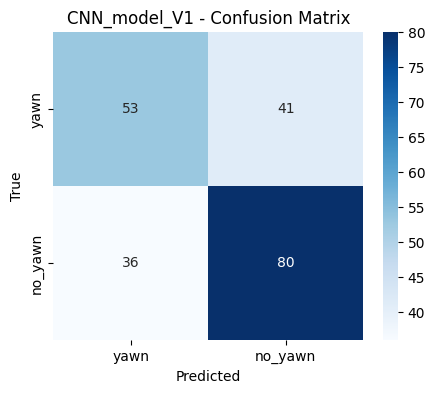

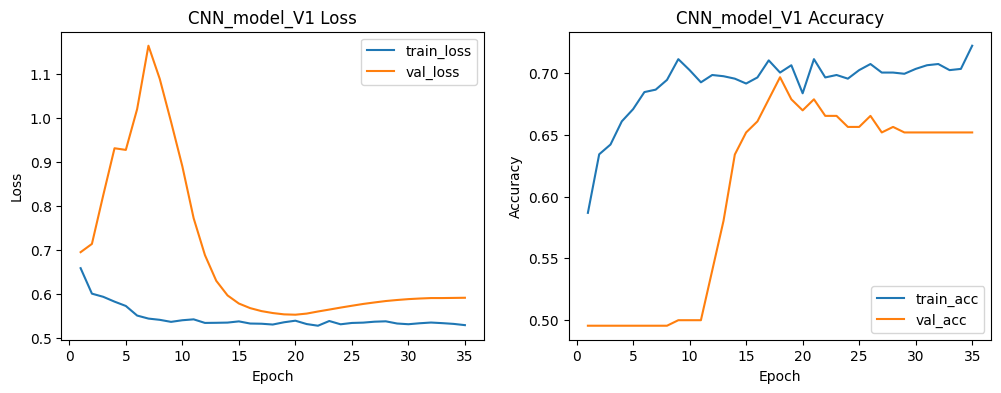



================ Training CNN_CBAM_model_V1 ================




Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.



Epoch 26: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 29: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6489 - loss: 0.6086

CNN_CBAM_model_V1 Test Loss: 0.6015, Test Accuracy: 0.6476

CNN_CBAM_model_V1 - Classification Report:

              precision    recall  f1-score   support

        yawn       0.60      0.64      0.62        94
     no_yawn       0.69      0.66      0.67       116

    accuracy                           0.65       210
   macro avg       0.65      0.65      0.65       210
weighted avg       0.65      0.65      0.65       210



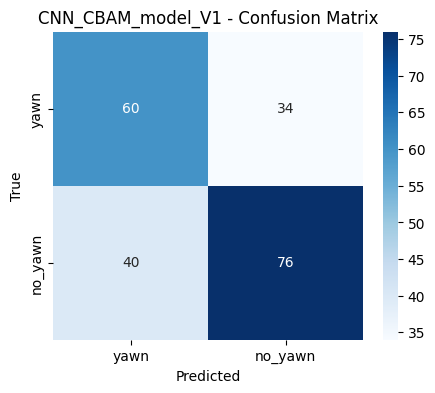

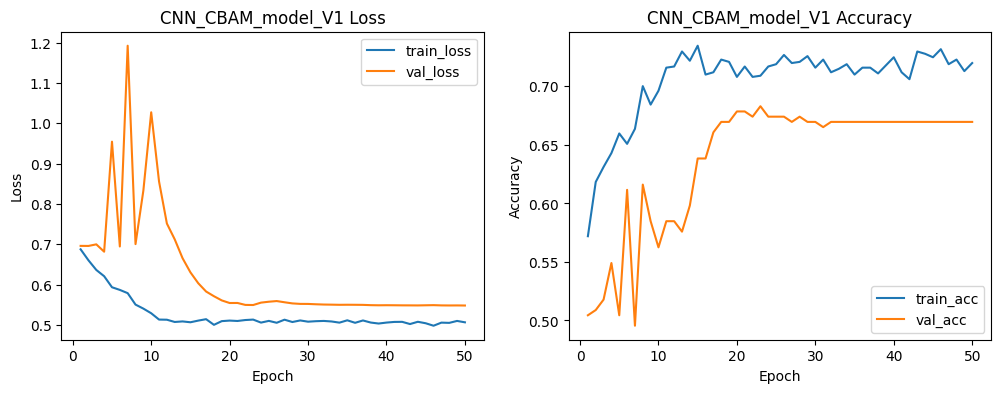



================ Training CNN_CBAM_model_V2 ================




Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Epoch 25: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 28: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9856 - loss: 0.0587

CNN_CBAM_model_V2 Test Loss: 0.0406, Test Accuracy: 0.9905



CNN_CBAM_model_V2 - Classification Report:

              precision    recall  f1-score   support

        yawn       0.99      0.99      0.99        94
     no_yawn       0.99      0.99      0.99       116

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



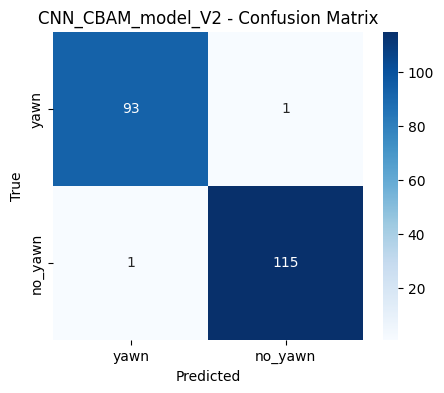

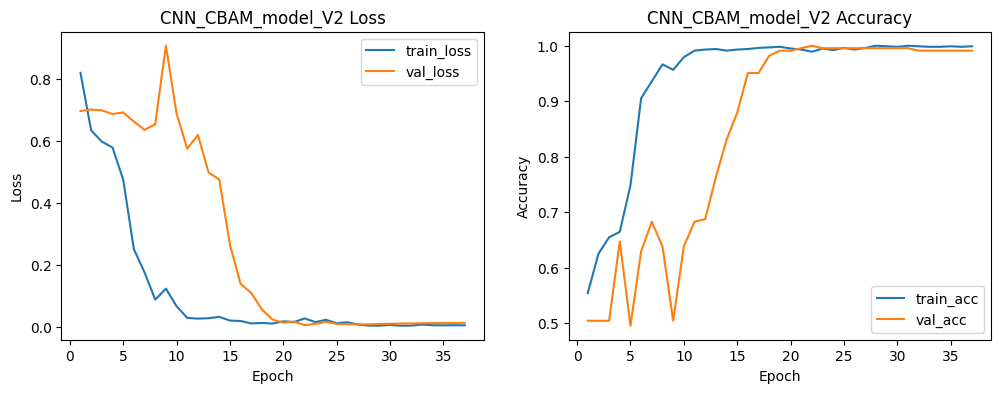

In [20]:
# Training and evaluation for custom models
for model_name, model in custom_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)




================ Training MobileNetV2_model ================




Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.



Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6966 - loss: 0.5388

MobileNetV2_model Test Loss: 0.5488, Test Accuracy: 0.7000



MobileNetV2_model - Classification Report:

              precision    recall  f1-score   support

        yawn       0.90      0.37      0.53        94
     no_yawn       0.65      0.97      0.78       116

    accuracy                           0.70       210
   macro avg       0.78      0.67      0.65       210
weighted avg       0.76      0.70      0.67       210



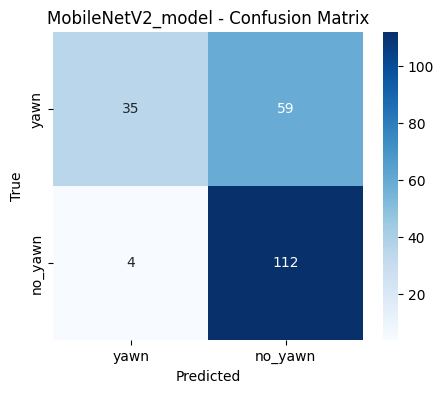

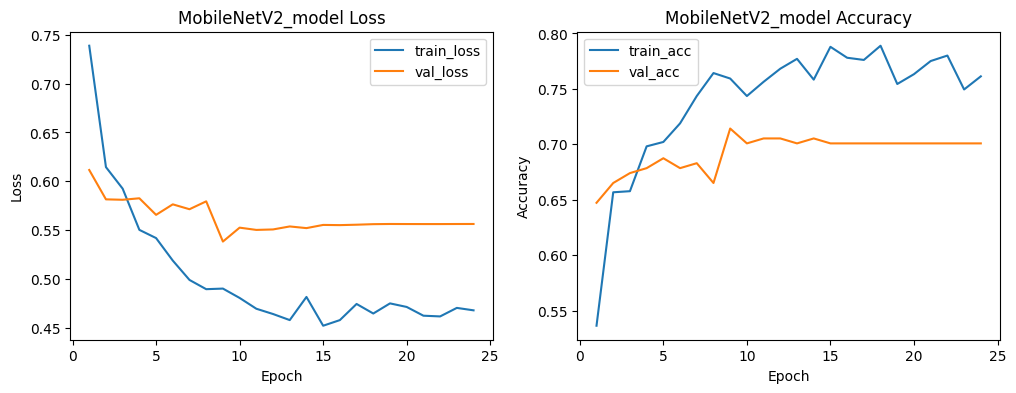



================ Training EfficientNetB0_model ================



E0000 00:00:1764127208.670003      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/efficientnet_b0_tl_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 39: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 42: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 45: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8699 - loss: 0.3368

EfficientNetB0_model Test Loss: 0.3582, Test Accuracy: 0.8571

EfficientNetB0_model - Classification Report:

              precision    recall  f1-score   support

        yawn       0.88      0.79      0.83        94
     no_yawn       0.84      0.91      0.88       116

    accuracy                           0.86       210
   macro avg       0.86      0.85      0.85       210
weighted avg       0.86      0.86      0.86       210



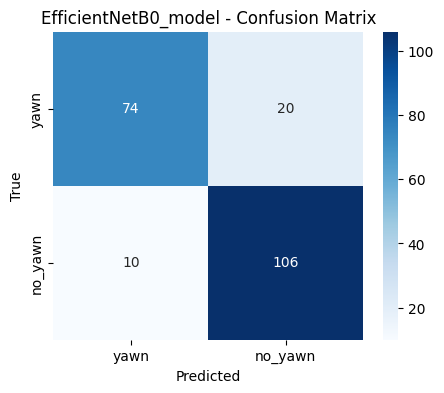

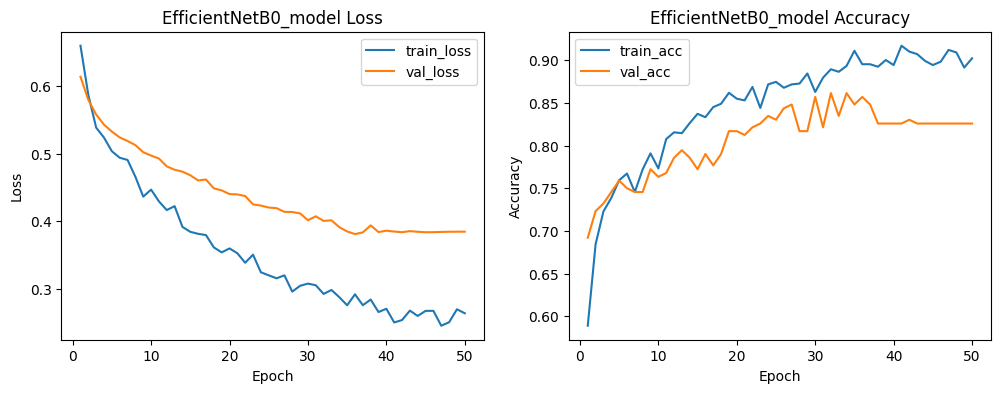



================ Training ResNet50_model ================




Epoch 32: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.

Epoch 49: ReduceLROnPlateau reducing learning rate to 1e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.8876 - loss: 0.2553

ResNet50_model Test Loss: 0.2291, Test Accuracy: 0.9000

ResNet50_model - Classification Report:

              precision    recall  f1-score   support

        yawn       0.89      0.88      0.89        94
     no_yawn       0.91      0.91      0.91       116

    accuracy                           0.90       210
   macro avg       0.90      0.90      0.90       210
weighted avg       0.90      0.90      0.90       210



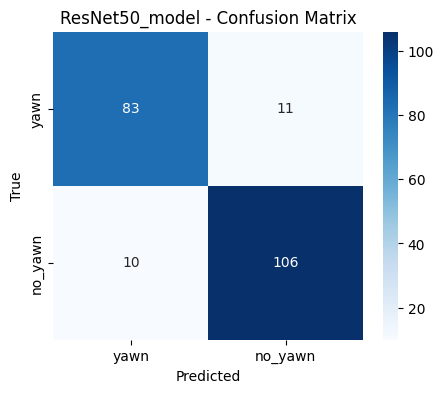

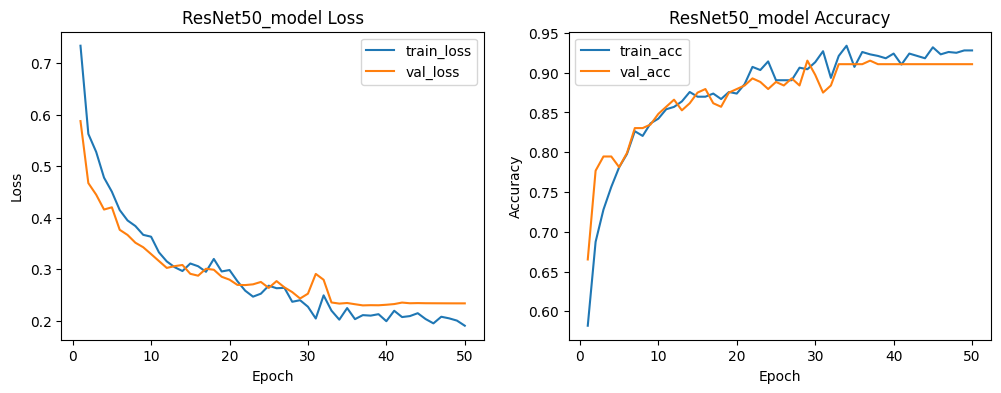



================ Training InceptionResNetV2_model ================




Epoch 19: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.



Epoch 40: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.

Epoch 49: ReduceLROnPlateau reducing learning rate to 1e-07.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.7784 - loss: 0.4833

InceptionResNetV2_model Test Loss: 0.4781, Test Accuracy: 0.7952

InceptionResNetV2_model - Classification Report:

              precision    recall  f1-score   support

        yawn       0.85      0.66      0.74        94
     no_yawn       0.77      0.91      0.83       116

    accuracy                           0.80       210
   macro avg       0.81      0.78      0.79       210
weighted avg       0.80      0.80      0.79       210



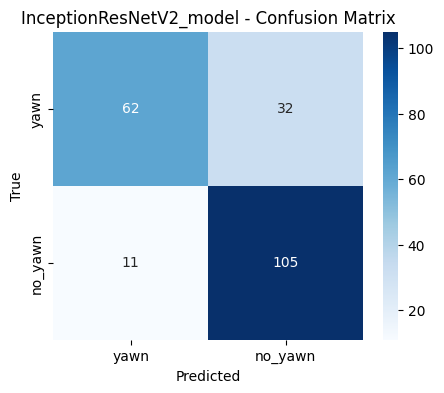

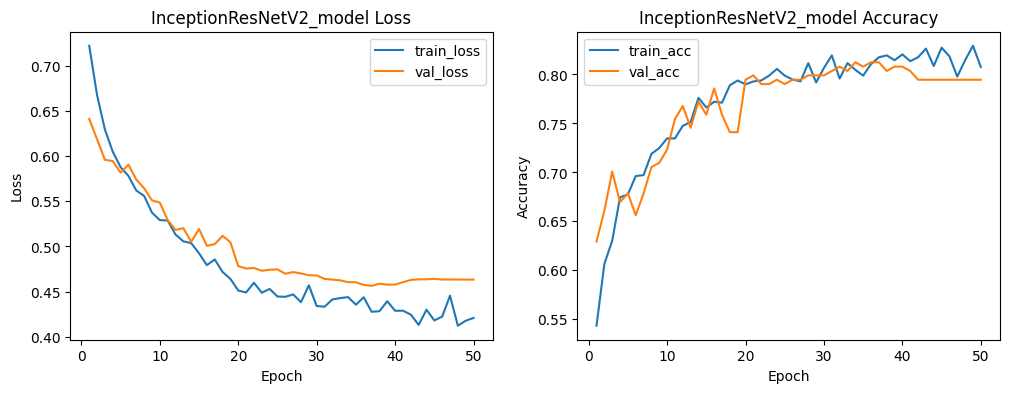



================ Training Xception_model ================




Epoch 45: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.8381 - loss: 0.4111

Xception_model Test Loss: 0.4133, Test Accuracy: 0.8238

Xception_model - Classification Report:

              precision    recall  f1-score   support

        yawn       0.85      0.73      0.79        94
     no_yawn       0.81      0.90      0.85       116

    accuracy                           0.82       210
   macro avg       0.83      0.82      0.82       210
weighted avg       0.83      0.82      0.82       210



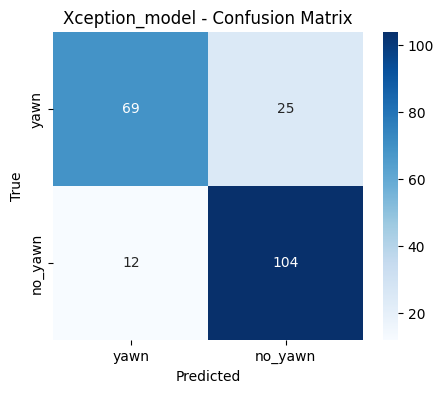

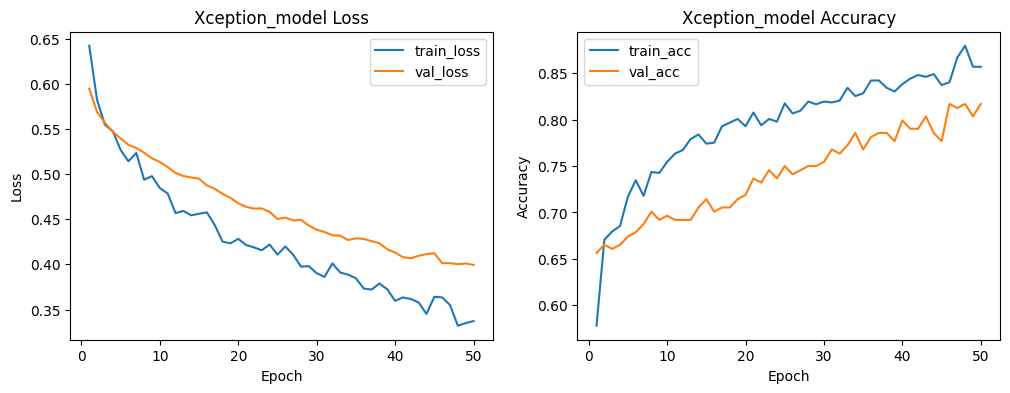

In [21]:


# Training and evaluation for transfer learning models
for model_name, model in transfer_learning_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)


### **GRAD CAM FOR CNN CBAM V2**

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

# ✅ Grad-CAM heatmap function for custom CNN
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute pooled grads
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv outputs with grads
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Overlay heatmap on image
def overlay_gradcam(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Ensure image is uint8
    if img.dtype != np.uint8:
        img = np.uint8(255 * img / np.max(img))

    # Resize heatmap to match input image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # convert from BGR → RGB

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img


def show_gradcam_samples(dataset, class_names, model, last_conv_layer_name, num_images=3):
    plt.figure(figsize=(12, 6))
    count = 0
    for images, labels in dataset.take(1):  # take 1 batch
        for i in range(min(num_images, images.shape[0])):
            img = images[i].numpy().astype("uint8")
            label = int(labels[i].numpy())  # ✅ cast to int

            img_array = np.expand_dims(images[i], axis=0)
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            superimposed_img = overlay_gradcam(img, heatmap)

            # Show original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(img)
            plt.title(f"True: {class_names[label]}")
            plt.axis("off")

            # Show GradCAM
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(superimposed_img)
            plt.title("GradCAM")
            plt.axis("off")

            count += 1
        break  # only take one batch
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_47/1847319493.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # ✅ cast to int
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_56']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


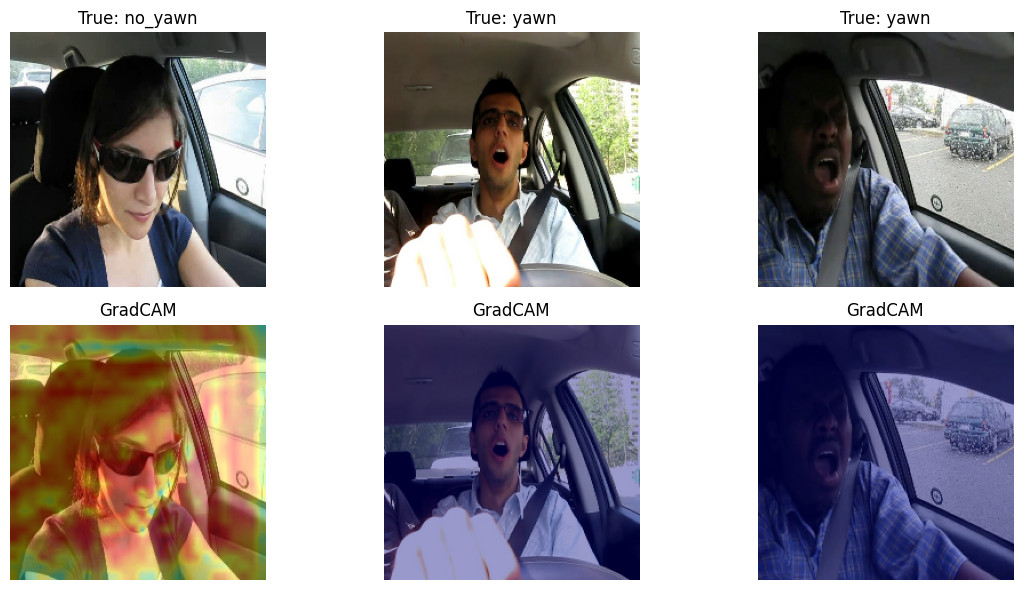

In [23]:
last_conv_layer_name = "conv2d_11"  # adjust if different in summary
show_gradcam_samples(test_ds, class_names, CNN_CBAM_model_V2, last_conv_layer_name)


/tmp/ipykernel_47/1847319493.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # ✅ cast to int


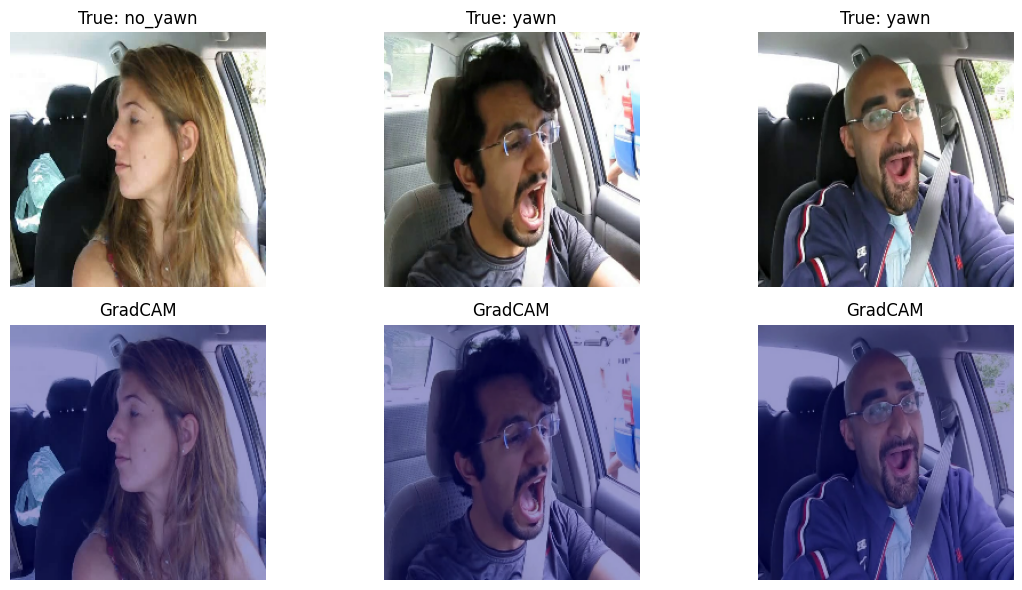

In [24]:
last_conv_layer_name = "conv2d_11"  # adjust if different in summary
show_gradcam_samples(train_ds, class_names, CNN_CBAM_model_V2, last_conv_layer_name)

### **For NTHU Dataset**

In [25]:
print("\n\n==============================")
print("DATASET 2 : NTU DDD2 (drowsy / notdrowsy)")
print("==============================")

data_dir = '/kaggle/input/nthuddd2/train_data'
TARGET_CLASSES = ['drowsy', 'notdrowsy']

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())

val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)






DATASET 2 : NTU DDD2 (drowsy / notdrowsy)
Found 66521 files belonging to 2 classes.
Using 46565 files for training.
Found 66521 files belonging to 2 classes.
Using 19956 files for validation.


### **Only take 1000 random images from each class for Fast Training**

In [26]:
import os
import random
import shutil
from pathlib import Path

print("\n\n==============================")
print("DATASET 2 : NTU DDD2 (1000 sampled per class)")
print("==============================")

# Original full dataset
data_dir = Path('/kaggle/input/nthuddd2/train_data')

# Temporary sampled dataset folder
sample_dir = Path('/kaggle/working/ntu_sample')
sample_dir.mkdir(exist_ok=True)

# Class names
TARGET_CLASSES = ['drowsy', 'notdrowsy']

# Create class folders inside working directory
for cls in TARGET_CLASSES:
    (sample_dir / cls).mkdir(exist_ok=True)

# Sample 1000 images per class
NUM_SAMPLES = 1000

for cls in TARGET_CLASSES:
    print(f"Sampling for class: {cls}")

    # List all files in this class folder
    cls_files = list((data_dir / cls).glob("*"))

    # Randomly pick 1000 files
    sampled_files = random.sample(cls_files, NUM_SAMPLES)

    # Copy sampled files to working folder
    for file in sampled_files:
        shutil.copy(file, sample_dir / cls)

print("Sampling complete! Using sampled dataset.")




DATASET 2 : NTU DDD2 (1000 sampled per class)
Sampling for class: drowsy
Sampling for class: notdrowsy
Sampling complete! Using sampled dataset.
Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.


In [31]:
# Class names
TARGET_CLASSES = ['drowsy', 'notdrowsy']


sample_dir = Path('/kaggle/working/ntu_sample')


# ------------------------------------------------
# Load dataset from sampled folder
# ------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    sample_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    sample_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())



val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.


### **Show Some Sample Images**

/tmp/ipykernel_47/4035756159.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # float→int


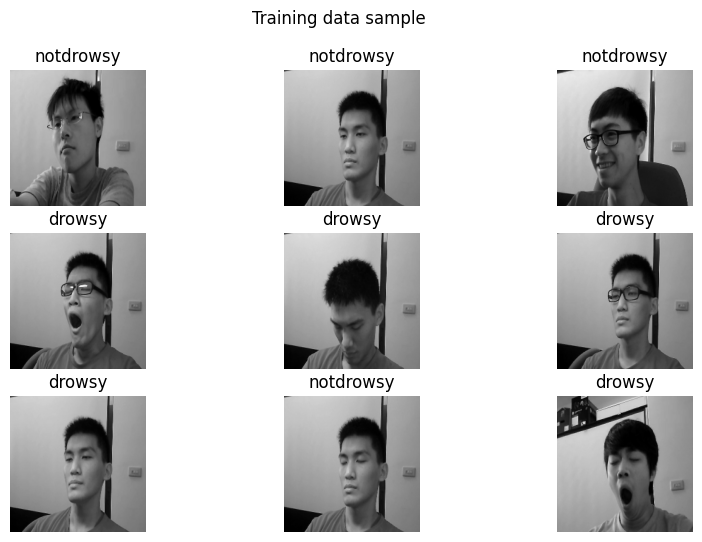

In [32]:

# -------------------------
# Optional: visualize some samples
# -------------------------
def show_batch(dataset, title="Sample images"):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = int(labels[i].numpy())  # float→int
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training data sample")

### **Check for Custom and transfer learning model**



================ Training CNN_model_V1 ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5379 - loss: 0.7871

CNN_model_V1 Test Loss: 0.7810, Test Accuracy: 0.5417

CNN_model_V1 - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.52      0.71      0.60       150
   notdrowsy       0.59      0.39      0.47       162

    accuracy                           0.54       312
   macro avg       0.55      0.55      0.53       312
weighted avg       0.55      0.54      0.53       312



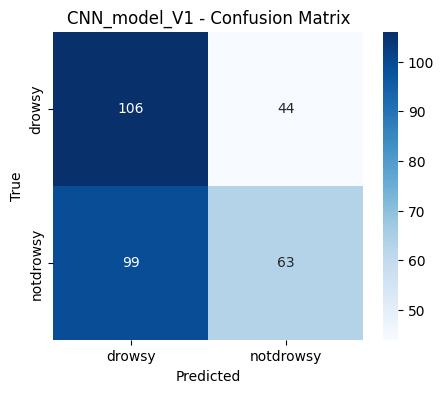

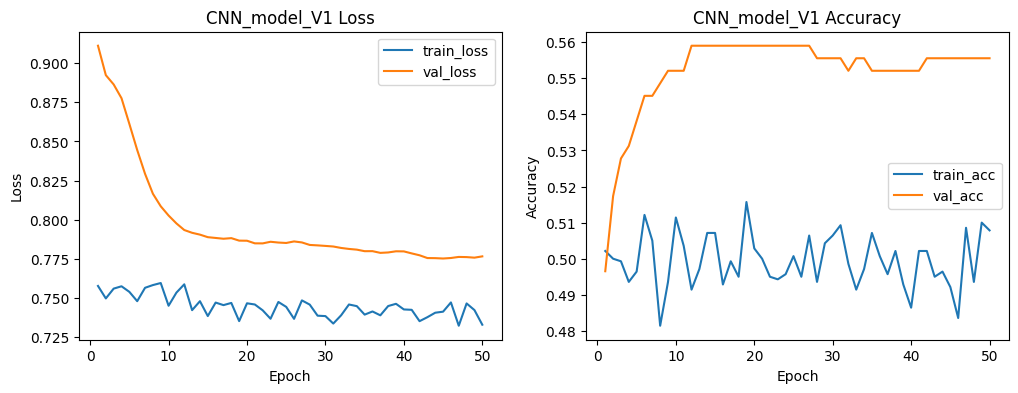



================ Training CNN_CBAM_model_V1 ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4925 - loss: 0.8546

CNN_CBAM_model_V1 Test Loss: 0.8326, Test Accuracy: 0.5128

CNN_CBAM_model_V1 - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.49      0.63      0.56       150
   notdrowsy       0.54      0.40      0.46       162

    accuracy                           0.51       312
   macro avg       0.52      0.52      0.51       312
weighted avg       0.52      0.51      0.51       312



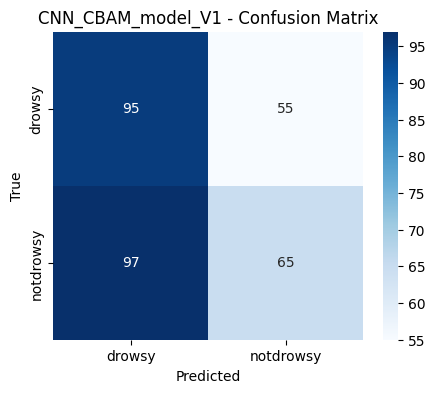

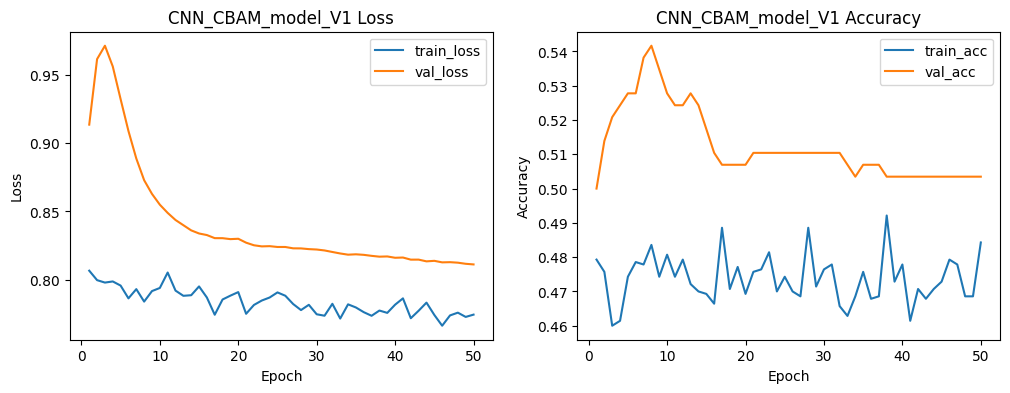



================ Training CNN_CBAM_model_V2 ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5307 - loss: 1.6039

CNN_CBAM_model_V2 Test Loss: 1.5515, Test Accuracy: 0.5353

CNN_CBAM_model_V2 - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.51      0.93      0.66       150
   notdrowsy       0.72      0.17      0.28       162

    accuracy                           0.54       312
   macro avg       0.61      0.55      0.47       312
weighted avg       0.62      0.54      0.46       312



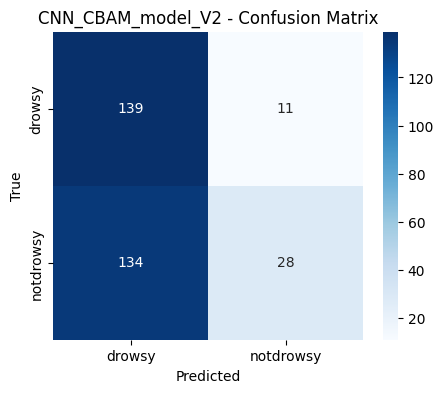

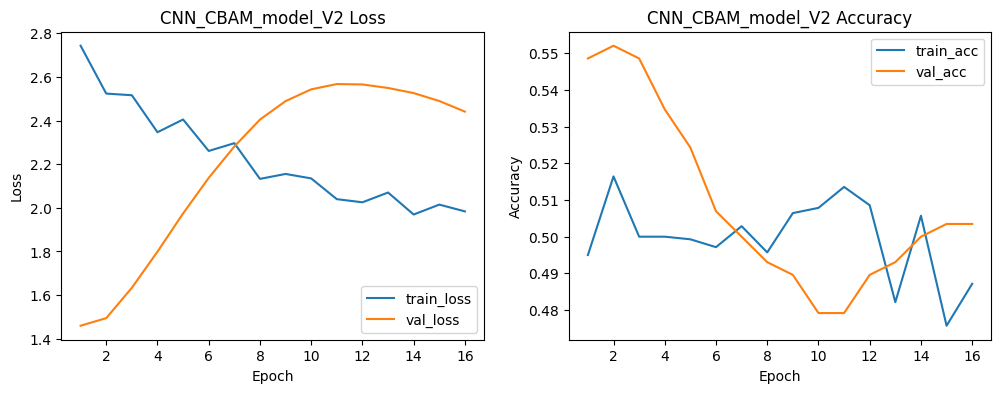

In [27]:
# train on custom model 
for model_name, model in custom_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)



================ Training MobileNetV2_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5389 - loss: 0.8174

MobileNetV2_model Test Loss: 0.8298, Test Accuracy: 0.5321

MobileNetV2_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       1.00      0.03      0.05       150
   notdrowsy       0.53      1.00      0.69       162

    accuracy                           0.53       312
   macro avg       0.76      0.51      0.37       312
weighted avg       0.75      0.53      0.38       312



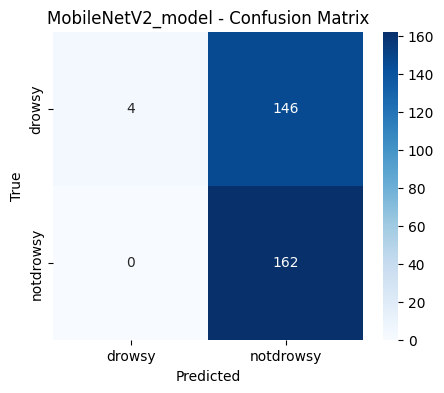

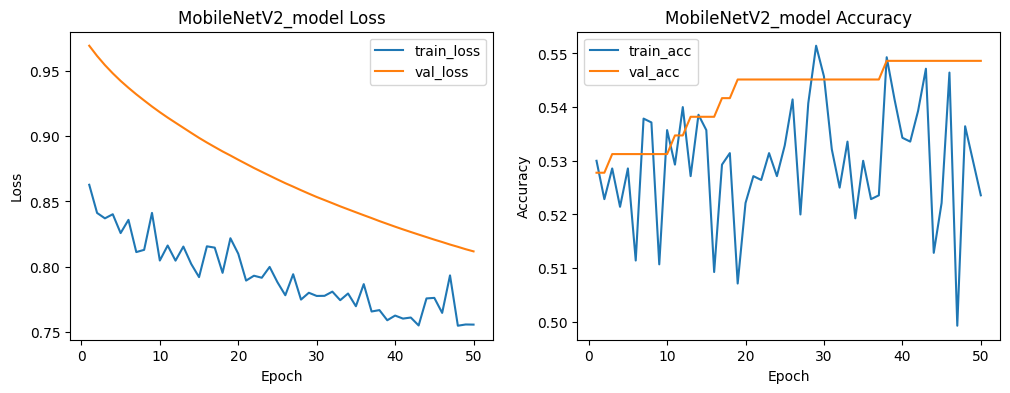



================ Training EfficientNetB0_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5461 - loss: 1.0143

EfficientNetB0_model Test Loss: 1.0363, Test Accuracy: 0.5449

EfficientNetB0_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       1.00      0.05      0.10       150
   notdrowsy       0.53      1.00      0.70       162

    accuracy                           0.54       312
   macro avg       0.77      0.53      0.40       312
weighted avg       0.76      0.54      0.41       312



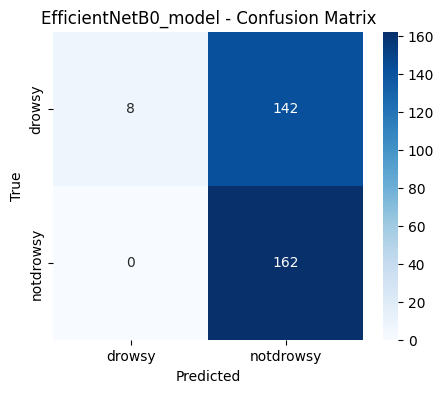

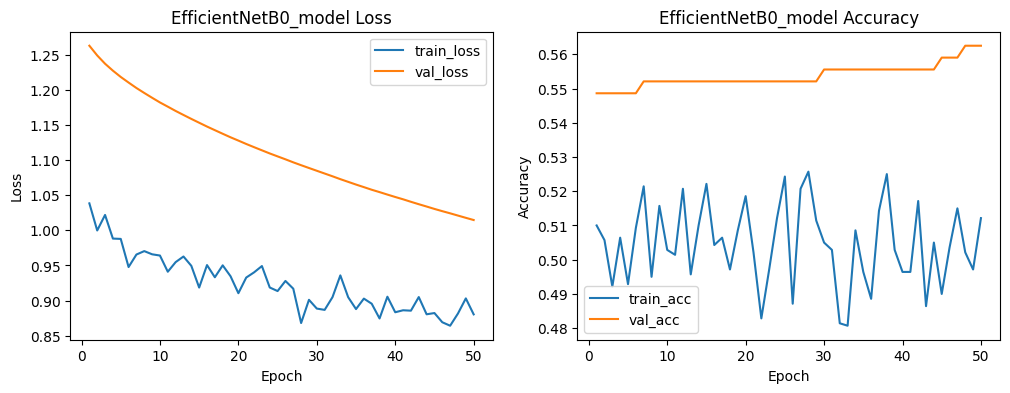



================ Training ResNet50_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5088 - loss: 1.1087

ResNet50_model Test Loss: 1.1623, Test Accuracy: 0.4968

ResNet50_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.46      0.27      0.34       150
   notdrowsy       0.51      0.70      0.59       162

    accuracy                           0.50       312
   macro avg       0.49      0.49      0.47       312
weighted avg       0.49      0.50      0.47       312



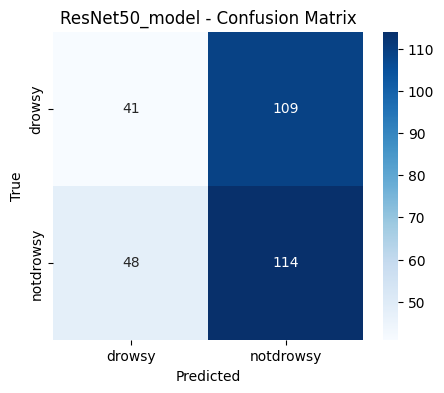

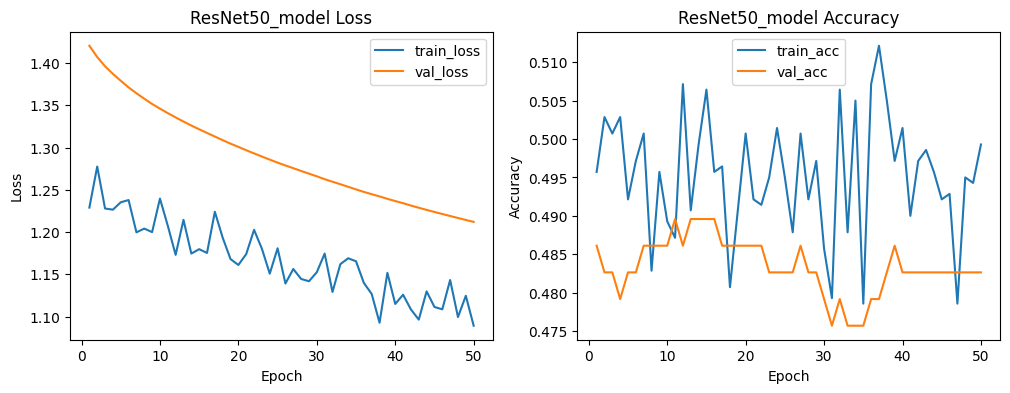



================ Training InceptionResNetV2_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4745 - loss: 0.7922

InceptionResNetV2_model Test Loss: 0.7872, Test Accuracy: 0.5064

InceptionResNetV2_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.48      0.28      0.35       150
   notdrowsy       0.52      0.72      0.60       162

    accuracy                           0.51       312
   macro avg       0.50      0.50      0.48       312
weighted avg       0.50      0.51      0.48       312



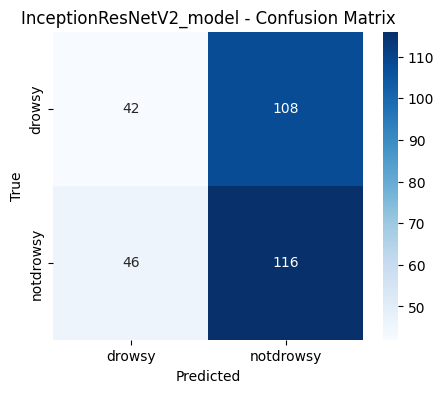

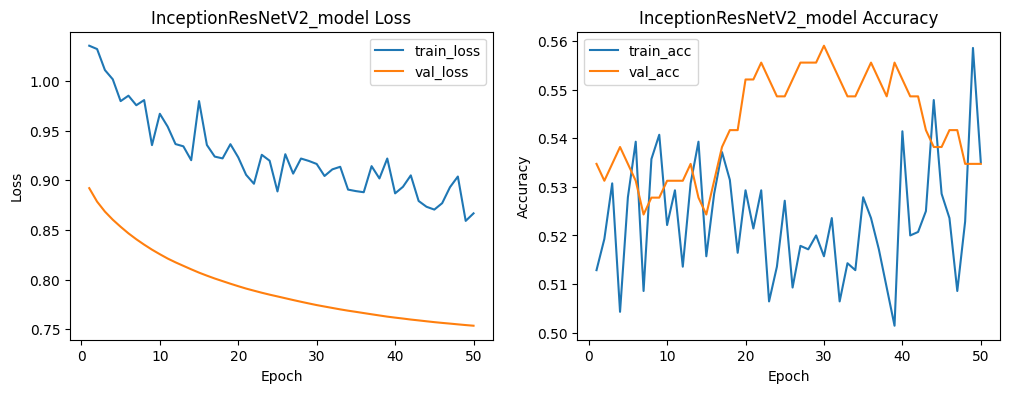



================ Training Xception_model ================




Epoch 37: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7235 - loss: 0.5572

Xception_model Test Loss: 0.5317, Test Accuracy: 0.7628

Xception_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.72      0.83      0.77       150
   notdrowsy       0.81      0.70      0.75       162

    accuracy                           0.76       312
   macro avg       0.77      0.77      0.76       312
weighted avg       0.77      0.76      0.76       312



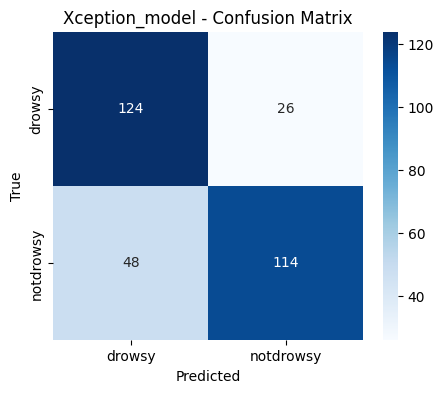

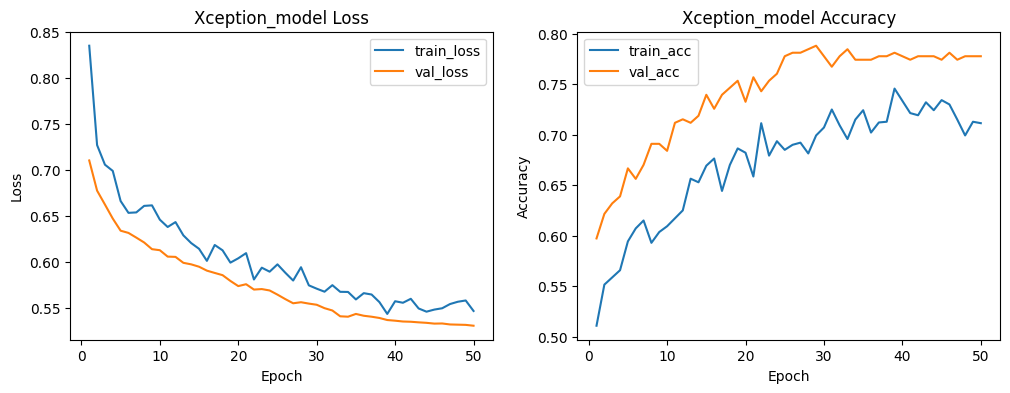

In [28]:

# Training and evaluation for transfer learning models
for model_name, model in transfer_learning_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)


### **For Driver Drowsiness Data (DDD)**

In [29]:
print("\n\n==============================")
print("DATASET 3 : DDD (Drowsy / Non Drowsy)")
print("==============================")

data_dir = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
TARGET_CLASSES = ['Drowsy', 'Non Drowsy']

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())

val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)




DATASET 3 : DDD (Drowsy / Non Drowsy)
Found 41793 files belonging to 2 classes.
Using 29256 files for training.
Found 41793 files belonging to 2 classes.
Using 12537 files for validation.


### **Take 1000 images from each class to train and test**

In [33]:
import os
import random
import shutil
from pathlib import Path

print("\n\n==============================")
print("DATASET 3 : DDD (1000 sampled per class)")
print("==============================")

# Original dataset path
data_dir = Path('/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)')

# New sampled dataset folder
sample_dir = Path('/kaggle/working/ddd_sample')
sample_dir.mkdir(exist_ok=True)

# Class names (must match folder names exactly)
TARGET_CLASSES = ['Drowsy', 'Non Drowsy']

# Create class folders inside working directory
for cls in TARGET_CLASSES:
    (sample_dir / cls).mkdir(exist_ok=True)

# Number of images to sample from each class
NUM_SAMPLES = 1000

# Loop through each class and sample images
for cls in TARGET_CLASSES:
    print(f"Sampling for class: {cls}")

    # List all image files in this class folder
    cls_files = list((data_dir / cls).glob("*"))

    # If class has fewer than required images, throw a warning
    if len(cls_files) < NUM_SAMPLES:
        print(f"Warning: Class {cls} has only {len(cls_files)} images, sampling all available.")

    # Randomly pick NUM_SAMPLES images
    sampled_files = random.sample(cls_files, min(NUM_SAMPLES, len(cls_files)))

    # Copy sampled images to the new directory
    for file in sampled_files:
        shutil.copy(file, sample_dir / cls)

print("Sampling complete! Using sampled DDD dataset.")






DATASET 3 : DDD (1000 sampled per class)
Sampling for class: Drowsy
Sampling for class: Non Drowsy
Sampling complete! Using sampled DDD dataset.


In [34]:
# New sampled dataset folder
sample_dir = Path('/kaggle/working/ddd_sample')

# Class names (must match folder names exactly)
TARGET_CLASSES = ['Drowsy', 'Non Drowsy']

# ------------------------------------------------
# Load dataset from sampled folder
# ------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    sample_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    sample_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

# Split val/test
class_names = train_ds.class_names
print("Class names (inferred):", class_names)

val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print("\nDataset sizes (batches):")
print("Train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test:", tf.data.experimental.cardinality(test_ds).numpy())


# Cache & prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.
Class names (inferred): ['Drowsy', 'Non Drowsy']

Dataset sizes (batches):
Train: 44
Val: 9
Test: 10


### **Show Sample Images**

/tmp/ipykernel_47/4035756159.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # float→int


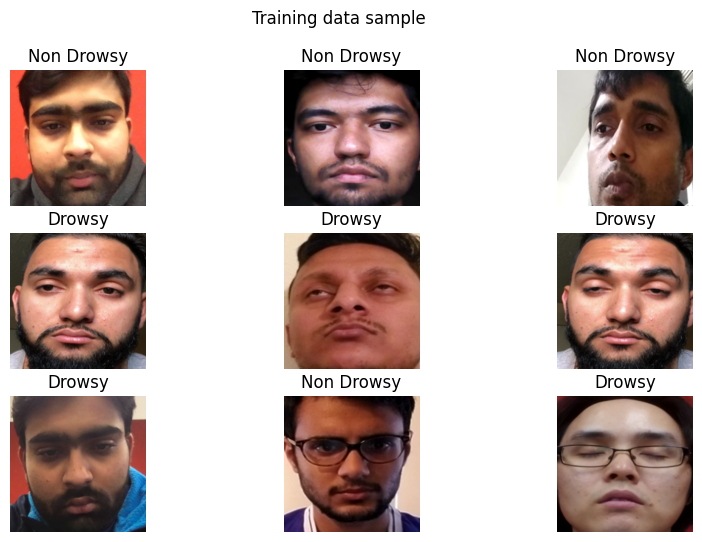

In [35]:

# -------------------------
# Optional: visualize some samples
# -------------------------
def show_batch(dataset, title="Sample images"):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = int(labels[i].numpy())  # float→int
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training data sample")



================ Training CNN_model_V1 ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5125 - loss: 0.7023

CNN_model_V1 Test Loss: 0.7024, Test Accuracy: 0.5224

CNN_model_V1 - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.50      0.75      0.60       150
  Non Drowsy       0.57      0.31      0.41       162

    accuracy                           0.52       312
   macro avg       0.54      0.53      0.50       312
weighted avg       0.54      0.52      0.50       312



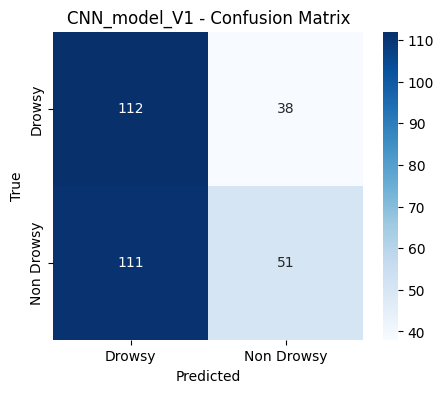

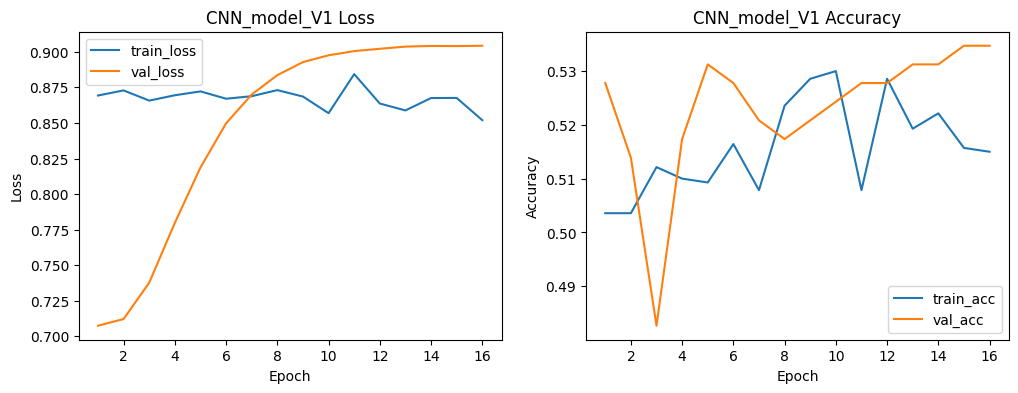



================ Training CNN_CBAM_model_V1 ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5142 - loss: 0.8183

CNN_CBAM_model_V1 Test Loss: 0.8051, Test Accuracy: 0.5321

CNN_CBAM_model_V1 - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.51      0.84      0.63       150
  Non Drowsy       0.62      0.25      0.35       162

    accuracy                           0.53       312
   macro avg       0.57      0.54      0.49       312
weighted avg       0.57      0.53      0.49       312



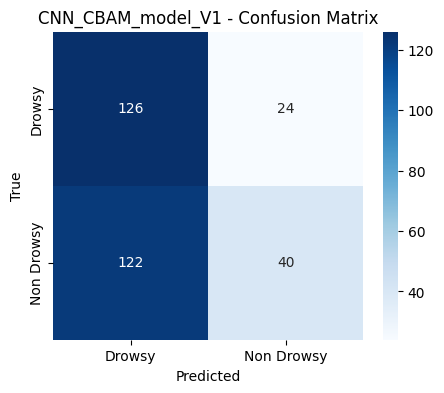

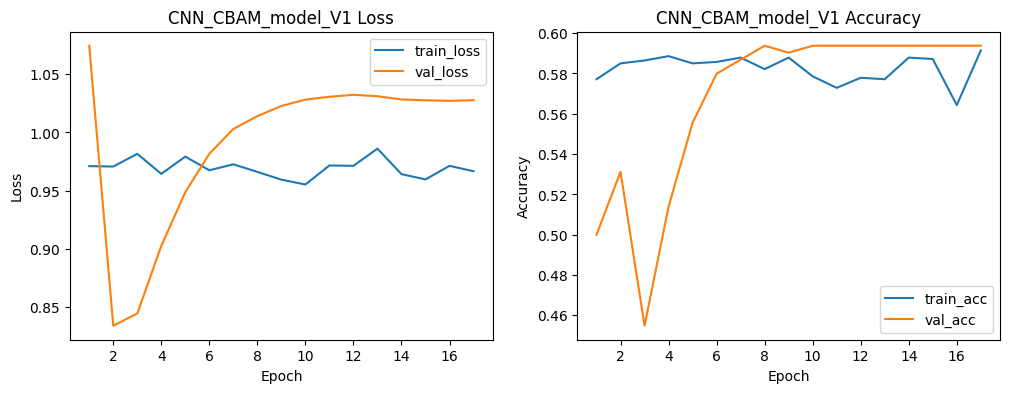



================ Training CNN_CBAM_model_V2 ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4546 - loss: 1.7899

CNN_CBAM_model_V2 Test Loss: 1.8733, Test Accuracy: 0.4647

CNN_CBAM_model_V2 - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.45      0.54      0.49       150
  Non Drowsy       0.48      0.40      0.43       162

    accuracy                           0.46       312
   macro avg       0.47      0.47      0.46       312
weighted avg       0.47      0.46      0.46       312



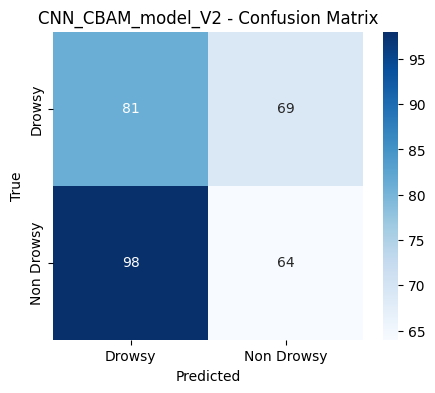

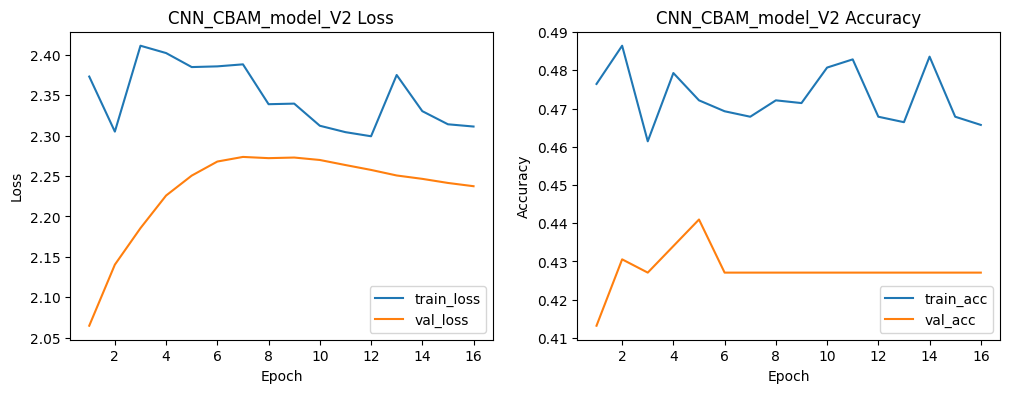

In [36]:
# Training and evaluation for custom models
for model_name, model in custom_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)



================ Training MobileNetV2_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4210 - loss: 0.8500

MobileNetV2_model Test Loss: 0.8661, Test Accuracy: 0.4167

MobileNetV2_model - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.42      0.56      0.48       150
  Non Drowsy       0.41      0.28      0.34       162

    accuracy                           0.42       312
   macro avg       0.42      0.42      0.41       312
weighted avg       0.42      0.42      0.41       312



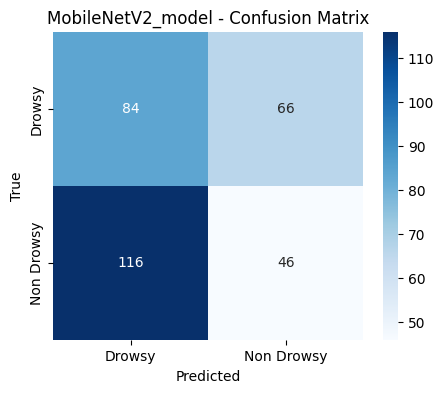

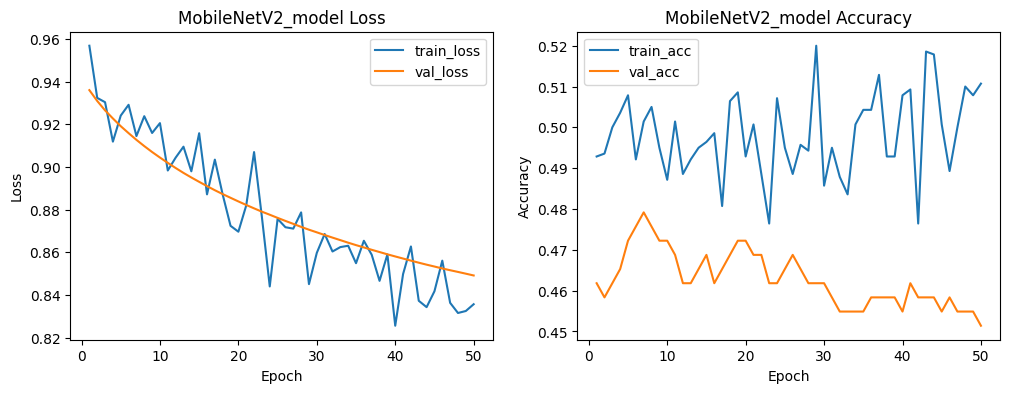



================ Training EfficientNetB0_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5265 - loss: 1.2844

EfficientNetB0_model Test Loss: 1.2979, Test Accuracy: 0.5128

EfficientNetB0_model - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.45      0.06      0.11       150
  Non Drowsy       0.52      0.93      0.67       162

    accuracy                           0.51       312
   macro avg       0.48      0.50      0.39       312
weighted avg       0.48      0.51      0.40       312



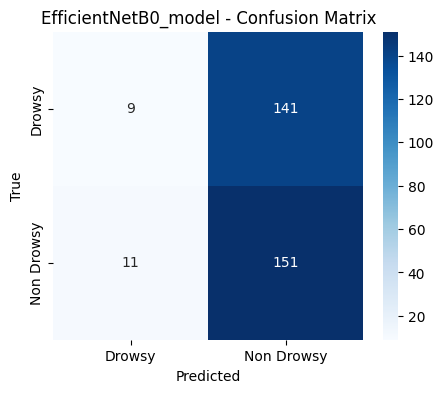

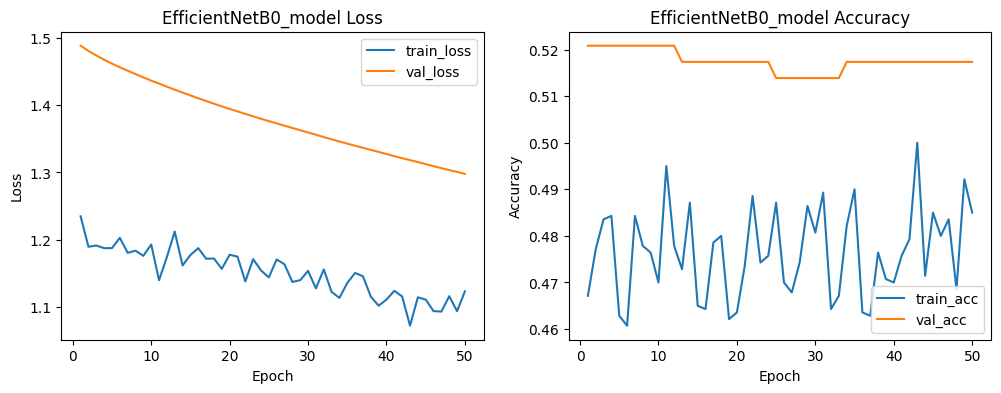



================ Training ResNet50_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5195 - loss: 1.1073

ResNet50_model Test Loss: 1.1913, Test Accuracy: 0.5224

ResNet50_model - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.50      0.72      0.59       150
  Non Drowsy       0.57      0.34      0.42       162

    accuracy                           0.52       312
   macro avg       0.53      0.53      0.51       312
weighted avg       0.54      0.52      0.51       312



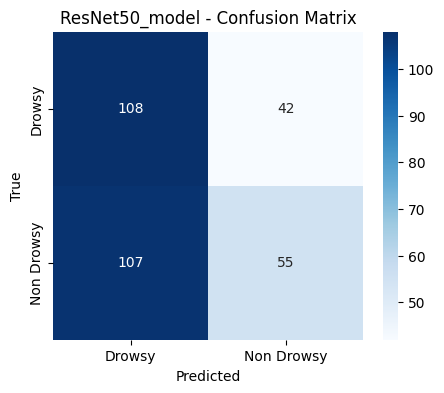

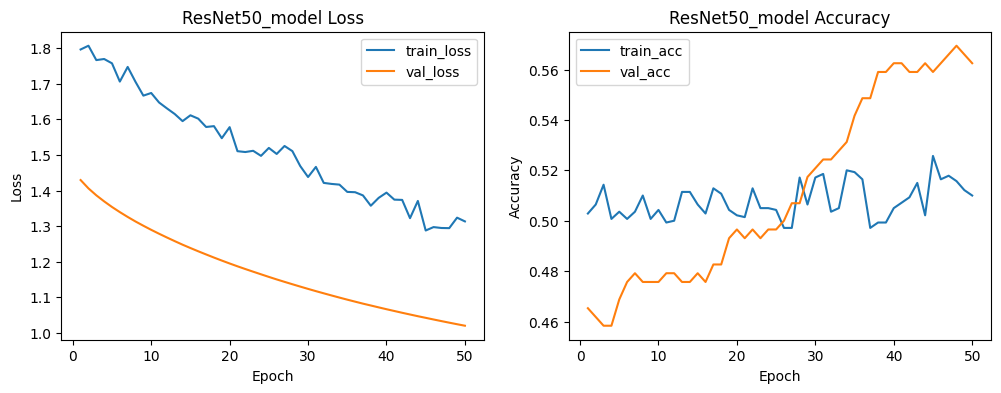



================ Training InceptionResNetV2_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5470 - loss: 0.8939

InceptionResNetV2_model Test Loss: 0.9326, Test Accuracy: 0.5353

InceptionResNetV2_model - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.55      0.18      0.27       150
  Non Drowsy       0.53      0.86      0.66       162

    accuracy                           0.54       312
   macro avg       0.54      0.52      0.47       312
weighted avg       0.54      0.54      0.47       312



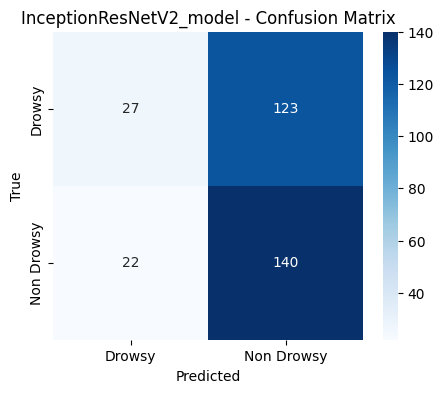

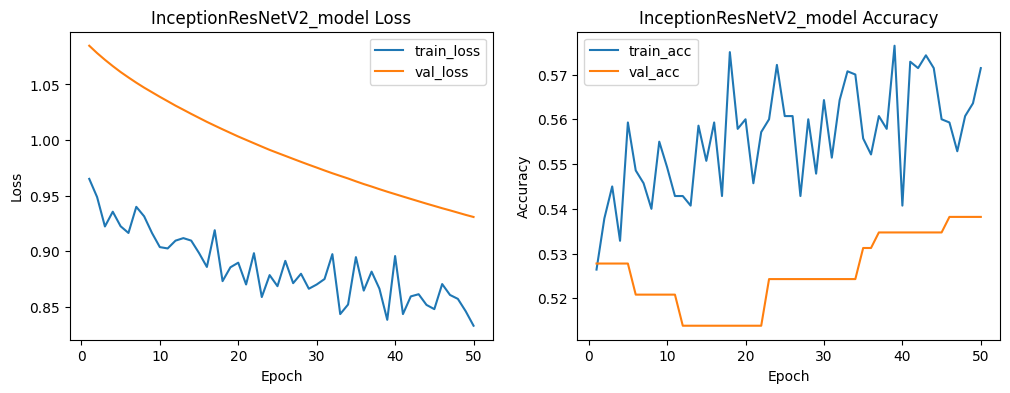



================ Training Xception_model ================



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7803 - loss: 0.5331

Xception_model Test Loss: 0.5320, Test Accuracy: 0.7981

Xception_model - Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.78      0.80      0.79       150
  Non Drowsy       0.81      0.80      0.80       162

    accuracy                           0.80       312
   macro avg       0.80      0.80      0.80       312
weighted avg       0.80      0.80      0.80       312



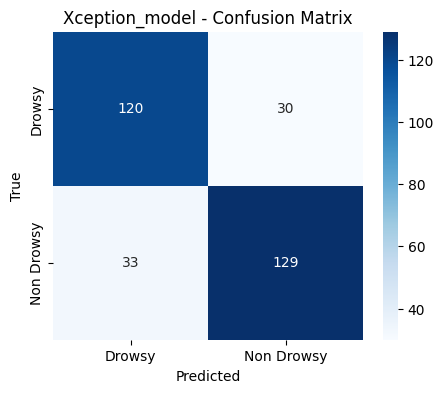

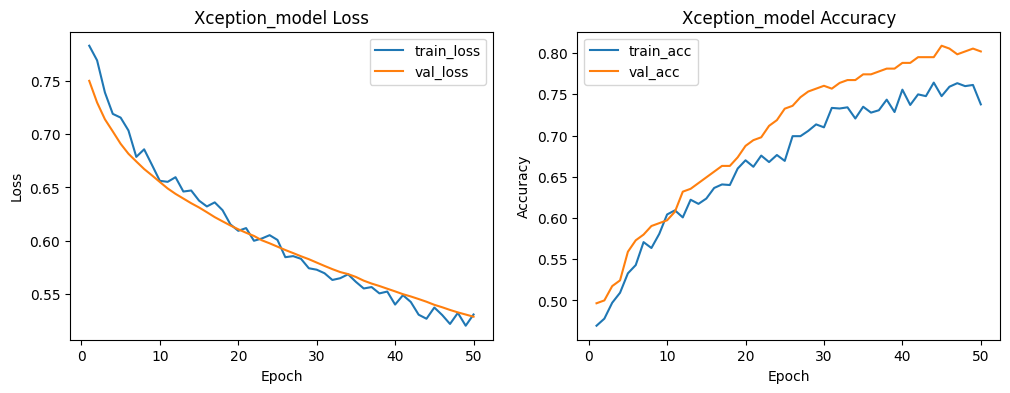

In [37]:

# Training and evaluation for transfer learning models
for model_name, model in transfer_learning_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)
